<a href="https://colab.research.google.com/github/brunacmendes/book-recommender-project/blob/main/DNN_keras_(versao_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division
from builtins import range, input

%matplotlib inline
from zipfile import ZipFile
from pathlib import Path
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
import tensorflow as tf


In [ ]:
# Load the Drive helper and mount
#from google.colab import drive

# This will prompt for authorization.
#drive.mount('/content/drive')

#df = pd.read_csv('/content/drive/MyDrive/amazon_ratings.csv')

# Carregar dados e Pre-processamento

In [6]:
bookcrossing_data_file_url = (
    "http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip"
)
BX_zipped_file = keras.utils.get_file(
    "BX-CSV-Dump.zip", bookcrossing_data_file_url, extract=False
)
keras_datasets_path = Path(BX_zipped_file).parents[0]
BX_dir = keras_datasets_path / 'book-crossing'

# Only extract the data the first time the script is run.
if not BX_dir.exists():
    with ZipFile(BX_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=BX_dir)
        print("Done!")

ratings_file = BX_dir / 'BX-Book-Ratings.csv'
r_cols = ['user_id', 'book_id', 'rating']
df = pd.read_csv(ratings_file, sep=';', names=r_cols, encoding='latin-1', low_memory=False)
df = df.drop(df.index[0])

In [7]:
df.head()

,user_id,book_id,rating
1,276725,034545104X,0
2,276726,0155061224,5
3,276727,0446520802,0
4,276729,052165615X,3
5,276729,0521795028,6


Agora preciso transformar os ids dos usuários e dos livros em ids únicos sequenciais começando do zero, para ser usado no modelo.

In [15]:
user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
book_ids = df["book_id"].unique().tolist()
book2book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded2book = {i: x for i, x in enumerate(book_ids)}
df["user"] = df["user_id"].map(user2user_encoded)
df["book"] = df["book_id"].map(book2book_encoded)

n_users = len(user2user_encoded)
n_books = len(book_encoded2book)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
# manter apenas as avaliações explicitas - nota 0 signfica que o usuario apenas interagiu com o produto de alguma forma
df=df.loc[df['rating']>0]
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of books: {}, Min rating: {}, Max rating: {}".format(
        n_users, n_books, min_rating, max_rating
    )
)

Number of users: 105283, Number of Movies: 340556, Min rating: 1.0, Max rating: 10.0


Para ter uma ideia melhor de como os dados se parecem, podemos transformá-los em uma tabela selecionando os 15 principais usuários/livros dos dados e juntando-os. O resultado mostra como cada um dos principais usuários classificou cada um dos livros principais.

In [16]:
g = df.groupby('user_id')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]

g = df.groupby('book_id')['rating'].count()
top_books = g.sort_values(ascending=False)[:15]

top_r = df.join(top_users, rsuffix='_r', how='inner', on='user_id')
top_r = top_r.join(top_books, rsuffix='_r', how='inner', on='book_id')

pd.crosstab(top_r.user_id, top_r.book_id, top_r.rating, aggfunc=np.sum)

book_id,0142001740,0312195516,0316666343,0316769487,0385504209,044023722X,0446672211,059035342X,067976402X,0679781587,0971880107
user_id,,,,,,,,,,,
11676,NaN,10.0,5.0,NaN,9.0,8.0,10.0,10.0,10.0,NaN,6.0
153662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,NaN,NaN
16795,10.0,9.0,10.0,8.0,10.0,NaN,8.0,NaN,NaN,NaN,NaN
189835,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235105,NaN,NaN,8.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
23902,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN
248718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
35859,9.0,10.0,6.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN
56399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


In [17]:
df.isnull().sum()

user_id    0
book_id    0
rating     0
user       0
book       0
dtype: int64

In [18]:
df.head(15)

,user_id,book_id,rating,user,book
2,276726,0155061224,5.0,1,1
4,276729,052165615X,3.0,3,3
5,276729,0521795028,6.0,3,4
7,276736,3257224281,8.0,5,6
8,276737,0600570967,6.0,6,7
9,276744,038550120X,7.0,7,8
10,276745,342310538,10.0,8,9
17,276747,0060517794,9.0,10,16
20,276747,0671537458,9.0,10,19
21,276747,0679776818,8.0,10,20


# Preparar dados de treinamento e de teste

In [30]:
# split into train and test

df = df.sample(frac=1, random_state=42)
x = df[["user", "book"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
X_train, X_test, y_train, y_test = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((390303, 2), (43368, 2), (390303,), (43368,))

In [48]:
n_factors = 10
#n_factors = 50

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

# Construção do modelo

In [49]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Add, Activation, Lambda
from keras.layers import Concatenate, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam, SGD
from keras.regularizers import l2

In [50]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

In [51]:
def RecommenderNet(n_users, n_books, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    book = Input(shape=(1,))
    m = EmbeddingLayer(n_books, n_factors)(book)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, book], outputs=x)
    opt = Adam(lr=0.001)
    #opt=SGD(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])

    return model

In [52]:
model = RecommenderNet(n_users, n_books, n_factors, min_rating, max_rating)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 10)        1052830     input_9[0][0]                    
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 10)        3405560     input_10[0][0]                   
____________________________________________________________________________________________

In [53]:
history = model.fit(x=X_train_array, 
                    y=y_train, 
                    batch_size=128,
                    #batch_size=64, 
                    epochs=5,
                    verbose=1, 
                    validation_data=(X_test_array, y_test)
                    )

Epoch 1/5
3050/3050 [==============================] - 131s 43ms/step - loss: 4.6534 - mean_squared_error: 4.6530 - val_loss: 0.1178 - val_mean_squared_error: 0.1162
Epoch 2/5
3050/3050 [==============================] - 130s 43ms/step - loss: 0.1821 - mean_squared_error: 0.1805 - val_loss: 0.1154 - val_mean_squared_error: 0.1138
Epoch 3/5
3050/3050 [==============================] - 131s 43ms/step - loss: 0.1507 - mean_squared_error: 0.1491 - val_loss: 0.1146 - val_mean_squared_error: 0.1132
Epoch 4/5
3050/3050 [==============================] - 130s 43ms/step - loss: 0.1293 - mean_squared_error: 0.1281 - val_loss: 0.1139 - val_mean_squared_error: 0.1131
Epoch 5/5
3050/3050 [==============================] - 132s 43ms/step - loss: 0.1173 - mean_squared_error: 0.1167 - val_loss: 0.1134 - val_mean_squared_error: 0.1131


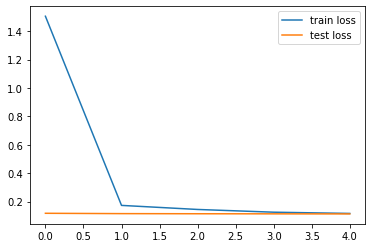

In [54]:
# plot losses
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="test loss")
plt.legend()
plt.show()

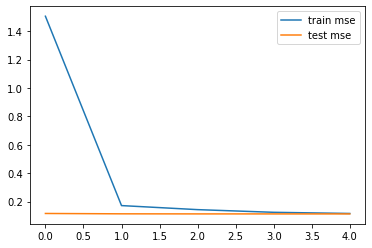

In [55]:
# plot mse
plt.plot(history.history['mean_squared_error'], label="train mse")
plt.plot(history.history['val_mean_squared_error'], label="test mse")
plt.legend()
plt.show()